In [1]:
import os
import cv2
import keras
from pickle import load,dump
from skimage import exposure
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.preprocessing import image
from keras.models import Sequential,Model,load_model
from keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,Flatten,Dense
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline  
#for inline graphical plotting

Using TensorFlow backend.


In [2]:
path = "../Dataset/UJTDchar/"
files = os.listdir(path)
character_list = os.listdir(path)
char_to_index = {}
index_to_char = {}
char_big_img = {}
char_small_img = {}
char_ab_threshold = []
num_classes = 124
print(len(character_list))
print(files)
for i in character_list:
    char_small_img[i] = 0  ##no of small images for each character
    char_big_img[i] = 0    ##no of large images for each character
#print(char_big_img)
x = []
threshold = 40
small_images = 0
avg_height = 0 
avg_width = 0 
valid_images = [".jpg",".gif",".png",".tga"]
dim = (32,32)

124
['ஞ', 'ெ', 'சீ', 'றீ', 'ங', 'ள்', 'ை', 'டு', 'தூ', 'ண்', 'U', 'ல', 'ே', 'று', 'யீ', 'லூ', 'லு', 'ரீ', 'னீ', 'நூ', 'ஙி', 'ற', 'ட்', 'பு', 'கீ', 'டீ', 'றி', 'ஞீ', 'ஙீ', 'லீ', 'ட', 'மூ', 'னி', 'னு', 'ஞி', 'ழூ', 'தி', 'யூ', 'I', 'பீ', 'ணீ', 'ற்', 'ணூ', 'டூ', 'ல்', 'லி', 'சூ', 'கு', 'ர', 'ணு', 'க', 'ந்', 'க்', 'Aa', 'றூ', 'ம', 'ம்', 'ஞூ', 'மி', 'வ', 'பூ', 'வி', 'சி', 'ஒ', 'ளூ', 'நி', 'கி', 'எ', 'ன', 'ஏ', 'மீ', 'ழி', 'தீ', 'ஙு', 'ரி', 'வீ', 'ரு', 'ர்', 'நீ', 'ழ்', 'ழ', 'ளி', 'கூ', 'ன்', 'நு', 'ங்', 'ளு', 'மு', 'வூ', 'ப', 'ரூ', 'யு', 'ந', 'ஐ', 'ச்', 'த', 'ஓ', 'ய்', 'ஙூ', 'ா', 'ணி', 'ய', 'ழீ', 'து', 'த்', 'ஞ்', 'பி', 'சு', 'ச', 'ப்', 'ஞு', 'ளீ', 'ள', 'வ்', 'னூ', 'ஃ', 'A', 'வு', 'Uu', 'ழு', 'யி', 'டி', 'ண', 'Ii']


In [3]:
def loading_images(valid_images,x,path,threshold,char_small_img,char_big_img,char_ab_threshold,files,character_list,dim,avg_height,avg_width,small_images):
    for i,file in enumerate(files):
        path1 = os.path.join(path,file)
        images = os.listdir(path1)
        for image in images:
            ext = os.path.splitext(image)
            if ext[1].lower() in valid_images:
                img = cv2.imread(os.path.join(path1,image),0)
                #img_eq = exposure.equalize_hist(img)
                avg_height = avg_height + img.shape[1]
                avg_width = avg_width + img.shape[0]
                if img.shape < dim:
                    small_images+=1
                    split = os.path.split(os.path.join(path1,image))
                    split1 = os.path.split(split[0])
                    if split1[1] in character_list:
                        char_small_img[split1[1]]+=1
                    img_resize = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
                else:
                    split = os.path.split(os.path.join(path1,image))
                    split1 = os.path.split(split[0])
                    if split1[1] in character_list:
                        char_big_img[split1[1]]+=1
                    img_resize = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
                x.append(img_resize)
    return x

In [4]:
x = loading_images(valid_images,x,path,threshold,char_small_img,char_big_img,char_ab_threshold,files,character_list,dim,avg_height,avg_width,small_images)

In [5]:
avg_height = (avg_height//12400)
avg_width = (avg_width//12400)
for key,val in char_big_img.items():
    if val > threshold:
        char_ab_threshold.append(key)
        #print(val)
#print(char_ab_threshold)

In [6]:
def load_img_for_11_classes():
    for i,file in enumerate(files):
        path1 = os.path.join(path,file)
        images = os.listdir(path1)
        for image in images:
            ext = os.path.splitext(image)
            if ext[1].lower() in valid_images:
                img = cv2.imread(os.path.join(path1,image),0)
                img_eq = exposure.equalize_hist(img)
                #blur = cv2.GaussianBlur(img,(5,5),0)
                if img.shape >= dim:
                    split = os.path.split(os.path.join(path1,image))
                    #print(split)
                    split1 = os.path.split(split[0])
                    #print(split1)
                    if split1[1] in char_ab_threshold:
                        img_resize = cv2.resize(img_eq, dim, interpolation = cv2.INTER_AREA)
                        x.append(img_resize)
                        #filenames.append(os.path.join(path1,image))

In [7]:
x_train = np.array(x)
x_train = np.expand_dims(x,axis=-1)
print(x_train.shape)

(12400, 32, 32, 1)


In [8]:
#plt.imshow(img_resize) ##sample image visualizing 

In [9]:
#label_to_char_mapping = {0 : 'A' , 1 : 'Aa' , 2 : 'I'}
#print(label_to_char_mapping)
def create_labels_for_11_classes():
    label_list = []
    temp = []
    """for j in range(0,len(char_ab_threshold)):    
        temp = [j for i in range(0,char_big_img[key]) if key in char_ab_threshold]
        label_list = label_list + temp
    """
    label_list = [0 for i in range(1,43)] + [1 for i in range(1,44)]+ [2 for i in range(1,43)] + [3 for i in range(1,46)] + [4 for i in range(1,43)] + [5 for i in range(1,42)] + [6 for i in range(1,46)] + [7 for i in range(1,43)]+ [8 for i in range(1,42)] + [9 for i in range(1,43)] + [10 for i in range(1,44)]
    print(label_list) 
    y_train = np.asarray(label_list)
    y_train = keras.utils.to_categorical(y_train, num_classes)
    print(y_train.shape)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42,stratified=y)
    print(x_train.shape)
    print(x_val.shape)
    print(y_train.shape)
    print(y_val.shape)

In [10]:
def prepare_labels(num_classes):
    #label_to_char_mapping = {0 : 'A' , 1 : 'Aa' , 2 : 'I'}
    #print(label_to_char_mapping)
    label_list = []
    for j in range(0,num_classes):
        temp = [j for i in range(1,101)]
        label_list = label_list + temp 
    print(label_list)    
    y_train = np.asarray(label_list)
    y_train = keras.utils.to_categorical(y_train, num_classes)
    print(y_train.shape)
    #x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.33, random_state=42)
    return y_train

In [11]:
def split_train_val(x_train,y_train):
    x_train,x_val,y_train,y_val = train_test_split(x_train,y_train,test_size=0.20,random_state=42,stratify=y_train)
    return x_train,x_val,y_train,y_val

In [12]:
def data_augment_train(x_train,y_train):
    x_train = x_train.astype('float32')
    datagen_train = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
    #os.makedirs('aug_images')
    datagen_train.fit(x_train)
    for X_batch, y_batch in datagen_train.flow(x_train, y_train, batch_size=9,save_to_dir='../Dataset/aug_images',save_format='jpg'):
        # create a grid of 3x3 images
        for i in range(0, 9):
            plt.subplot(330 + 1 + i)
            plt.imshow(X_batch[i].reshape(32,32),cmap=plt.get_cmap('gray'))
        # show the plot
        plt.show()
        break
    return datagen_train

In [13]:
def data_augment_val(x_val,y_val):
    x_val = x_val.astype('float32')
    datagen_val = ImageDataGenerator(featurewise_center=True,featurewise_std_normalization=True)
    datagen_val.fit(x_val)
    for X_batch,y_batch in datagen_val.flow(x_val,y_val,batch_size=9):
        for i in range(0,9):
            plt.subplot(330 + 1 + i)
            plt.imshow(X_batch[i].reshape(32,32),cmap=plt.get_cmap('gray'))
        plt.show()
        break
    return datagen_val

In [14]:
#label_list = [0 for i in range(1,101)] + [1 for i in range(1,101)]+ [2 for i in range(1,101)]
#label_to_char_mapping = {0 : 'A' , 1 : 'Aa' , 2 : 'I'}
#print(label_to_char_mapping)
y_train = prepare_labels(num_classes)
x_train,x_val,y_train,y_val = split_train_val(x_train,y_train)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 

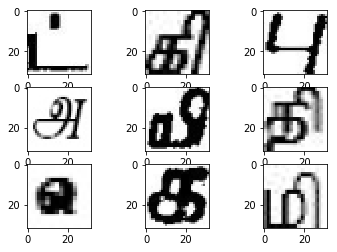

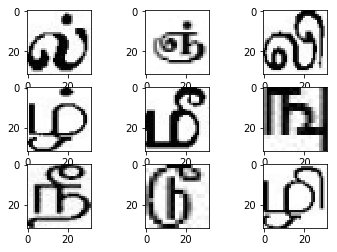

In [15]:
datagen_train = data_augment_train(x_train,y_train)
datagen_val = data_augment_val(x_val,y_val)

In [19]:
#train_generator = datagen_train.flow_from_directory(path,target_size=(32,32),batch_size=32,save_to_dir="aug_images1",save_format='jpg')
directory_list = os.listdir("../Dataset/UJTDchar/")
for i,char in enumerate(directory_list):
    char_to_index[char] = i  
print(char_to_index)
for key,val in char_to_index.items():
    index_to_char[val] = key
#datagen_train.fit
#print(index_to_char)

{'ஞ': 0, 'ெ': 1, 'சீ': 2, 'றீ': 3, 'ங': 4, 'ள்': 5, 'ை': 6, 'டு': 7, 'தூ': 8, 'ண்': 9, 'U': 10, 'ல': 11, 'ே': 12, 'று': 13, 'யீ': 14, 'லூ': 15, 'லு': 16, 'ரீ': 17, 'னீ': 18, 'நூ': 19, 'ஙி': 20, 'ற': 21, 'ட்': 22, 'பு': 23, 'கீ': 24, 'டீ': 25, 'றி': 26, 'ஞீ': 27, 'ஙீ': 28, 'லீ': 29, 'ட': 30, 'மூ': 31, 'னி': 32, 'னு': 33, 'ஞி': 34, 'ழூ': 35, 'தி': 36, 'யூ': 37, 'I': 38, 'பீ': 39, 'ணீ': 40, 'ற்': 41, 'ணூ': 42, 'டூ': 43, 'ல்': 44, 'லி': 45, 'சூ': 46, 'கு': 47, 'ர': 48, 'ணு': 49, 'க': 50, 'ந்': 51, 'க்': 52, 'Aa': 53, 'றூ': 54, 'ம': 55, 'ம்': 56, 'ஞூ': 57, 'மி': 58, 'வ': 59, 'பூ': 60, 'வி': 61, 'சி': 62, 'ஒ': 63, 'ளூ': 64, 'நி': 65, 'கி': 66, 'எ': 67, 'ன': 68, 'ஏ': 69, 'மீ': 70, 'ழி': 71, 'தீ': 72, 'ஙு': 73, 'ரி': 74, 'வீ': 75, 'ரு': 76, 'ர்': 77, 'நீ': 78, 'ழ்': 79, 'ழ': 80, 'ளி': 81, 'கூ': 82, 'ன்': 83, 'நு': 84, 'ங்': 85, 'ளு': 86, 'மு': 87, 'வூ': 88, 'ப': 89, 'ரூ': 90, 'யு': 91, 'ந': 92, 'ஐ': 93, 'ச்': 94, 'த': 95, 'ஓ': 96, 'ய்': 97, 'ஙூ': 98, 'ா': 99, 'ணி': 100, 'ய': 101, 'ழீ': 102, 'த

In [40]:
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(32,32,1)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Conv2D(64,(3 , 3) , activation = 'relu'))
    model.add(Conv2D(64,(3 , 3) , activation = 'relu'))
    model.add(Conv2D(64,(3 , 3) , activation = 'relu'))
    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(124,activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    checkpointer = ModelCheckpoint(filepath='modelzca2.hdf5',monitor='val_loss',verbose=1, save_best_only=True)
    earlystopping = EarlyStopping(monitor='val_loss',patience=10)
    history = model.fit_generator(datagen_train.flow(x_train, y_train, batch_size=32),
                        steps_per_epoch=x_train.shape[0] // 32,
                        epochs=50,validation_data=datagen_val.flow(x_val,y_val,batch_size=32),callbacks=[checkpointer,earlystopping])
    with open('trainHistoryzca2124.pkl', 'wb') as fp:
        dump(history.history, fp)
    return model
    #model.fit(x_train, y_train,batch_size=32,epochs=100,verbose=1,validation_split=0.2)

In [41]:
model = cnn_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 10, 10, 64)        18496     
__________

KeyboardInterrupt: 

In [20]:
def load_test_image(model):
    imgA = cv2.imread('../Dataset/aug_images/_8280_2238.jpg',0)
    #img_eqA = exposure.equalize_hist(imgA)
    img_resizeA = cv2.resize(imgA, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(img_resizeA)
    x1 = np.array(img_resizeA)
    x1 = np.expand_dims(x1,axis=-1)
    x1 = np.expand_dims(x1,axis=0)
    prediction = model.predict(x1)  ##this doesn't work , it's predicting same class all the time
    return prediction

In [37]:
loaded_model = load_model('model.hdf5')
##prediction = load_test_image(loaded_model)
##print(prediction)
##print(prediction.shape)
##y_classes = prediction.argmax(axis=-1)
##print(y_classes)

In [47]:
def test_model_on_image(model,img_path):
    imgA = cv2.imread(img_path,0) 
    #img_eqA = exposure.equalize_hist(imgA)
    img_resizeA = cv2.resize(imgA, dim, interpolation = cv2.INTER_AREA)
    plt.imshow(img_resizeA)
    x1 = np.array(img_resizeA)
    x1 = np.expand_dims(x1,axis=-1)
    x1 = np.expand_dims(x1,axis=0)
    generator = datagen_val.flow(x1,
            batch_size=1,shuffle=False)  
    probabilities = loaded_model.predict_generator(generator,1)
    #print(probabilities)
    classes = probabilities.argmax(axis=-1)
    print("Class : ",classes)
    char = int(classes)
    print(index_to_char[char])

Class :  [30]
ட


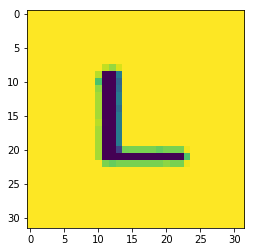

In [48]:
test_model_on_image(loaded_model,'../index.png')  ##random image downloaded from internet

Class :  [95]
த


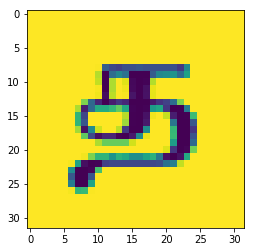

In [49]:
test_model_on_image(loaded_model,'../index2.png')  ##random image downloaded from internet

Class :  [44]
ல்


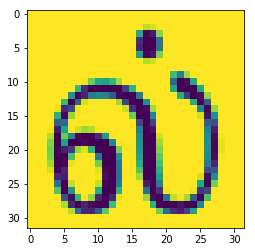

In [50]:
test_model_on_image(loaded_model,'../index3.png') ##random image downloaded from internet

In [283]:
def plot_model():
    history = load(open("trainHistoryzca124.pkl", "rb"))
    print(history['acc'])
    print(history.keys())
    # summarize history for accuracy
    plt.plot(history['acc'])
    plt.plot(history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('model_accuracyzca124.png')
    plt.show()
    # summarize history for loss
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.savefig('model_losszca124.png')
    plt.show()

[0.33770161290322581, 0.69606854838709675, 0.79506048387096773, 0.84112903225806457, 0.87822580645161286, 0.89868951612903225, 0.9199596774193548, 0.92812499999999998, 0.93860887096774193, 0.94425403225806448, 0.95292338709677415, 0.95695564516129028, 0.96572580645161288, 0.96552419354838714, 0.95816532258064513, 0.97046370967741935, 0.96441532258064511, 0.97056451612903227, 0.97620967741935483, 0.97399193548387097, 0.97671370967741933, 0.97278225806451613, 0.9790322580645161, 0.97782258064516125, 0.97883064516129037]
dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


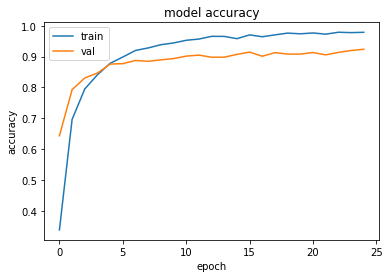

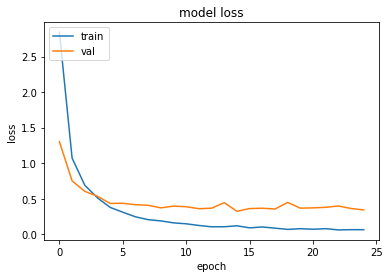

In [284]:
plot_model()